In [6]:
import torch
import pandas as pd

from transformers import AutoConfig, AutoTokenizer, AutoModel, pipeline, BertForSequenceClassification
from transformers import logging as hflogging
from transformers import pipeline

In [5]:
data = pd.read_csv("Data/pairs_with_ratings.tsv",sep="\t")  # CSV with columns 'text' and 'label'
data = data.drop_duplicates(["original_id"])

In [26]:
target = ([1]*len(data["original_title"]))+([0]*len(data["title"]))
tiltes = (data["original_title"] + data["title"])

In [28]:
pd.concat([data["original_title"], data["title"]], axis=0)

0       Partially Faded Hand Stamp Undermining Everyth...
7       Synthesizer Trumpet Announces Arrival Of Porn ...
15      Depressed Security Guard Turns Big Flashlight ...
22      Fugitive Doctor Accuses Devlin MacGregor Of Fr...
30      AIG Nearly Blows All The Goodwill Built Up By ...
                              ...                        
5653    Red Lobster Celebrates Return Of Annual All-Yo...
5658    Breaking: LeBron James Leaning Toward Joining ...
5660    Study Finds People On Dates Know Within 30 Sec...
5664    Man Needs Verbal Assurance That Hand Stamp Wil...
5666    God Pledges $5,000 For Cancer ResearchGATES PL...
Length: 1191, dtype: object

In [27]:
print(len(tiltes))
print(len(target))

1191
2382


In [29]:
clean_data = pd.DataFrame({"titles":pd.concat([data["original_title"], data["title"]], axis=0),
                         "humor":[1]*len(data["original_title"])+[0]*len(data["title"])})

In [43]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Load your dataset from a CSV file
data = pd.read_csv("Data/pairs_with_ratings.tsv",sep="\t")  # CSV with columns 'text' and 'label'

data = data.drop_duplicates(["original_id"])

clean_data = pd.DataFrame({"titles":pd.concat([data["original_title"], data["title"]], axis=0),
                         "label":[1]*len(data["original_title"])+[0]*len(data["title"])})

# Split dataset into train and test
train_df, test_df = train_test_split(clean_data, test_size=0.2, random_state=42)

# Convert pandas DataFrame to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [42]:
train_dataset.features

{'titles': Value(dtype='string', id=None),
 'humor': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [67]:

# Load the BERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def preprocess_data(examples):
    return tokenizer(examples['titles'], padding="max_length", truncation=True, max_length=128)

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Set the format for PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 477/477 [00:00<00:00, 13544.49 examples/s]


In [68]:
class TransformerBinaryClassifier(torch.nn.Module):

    def __init__(self, plm_name: str):
        super(TransformerBinaryClassifier, self).__init__()
        self.lmconfig = AutoConfig.from_pretrained(plm_name)
        self.lmtokenizer = AutoTokenizer.from_pretrained(plm_name)
        self.lm = AutoModel.from_pretrained(plm_name, output_attentions=False)
        self.emb_dim = self.lmconfig.hidden_size
        self.output_size = 1
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(self.emb_dim, self.output_size),
            torch.nn.Sigmoid()
        )
        self.loss_fn = torch.nn.BCELoss(reduction='mean')


    def forward(self, x):
        #  x['input_ids']  -> N,T,d
        x : torch.Tensor = self.lm(x['input_ids'], x['attention_mask']).last_hidden_state
        global_vects = x.mean(dim=1)   #  N,d
        x = self.classifier(global_vects)
        return x.squeeze(-1)

    def compute_loss(self, predictions, target):
        return self.loss_fn(predictions, target)
    
model = TransformerBinaryClassifier("bert-base-uncased")

In [70]:

X_train_encoded = model.lmtokenizer(train_dataset["titles"],
                            truncation=True,
                            padding=False,
                            add_special_tokens=False,
                            return_tensors=None,
                            return_offsets_mapping=False,
                        )

X_test_encoded = model.lmtokenizer(test_dataset["titles"],
                            truncation=True,
                            padding=False,
                            add_special_tokens=False,
                            return_tensors=None,
                            return_offsets_mapping=False,
                        )

In [76]:
len(X_train_encoded[0])

13

Text(0.5, 1.0, 'Length of titles')

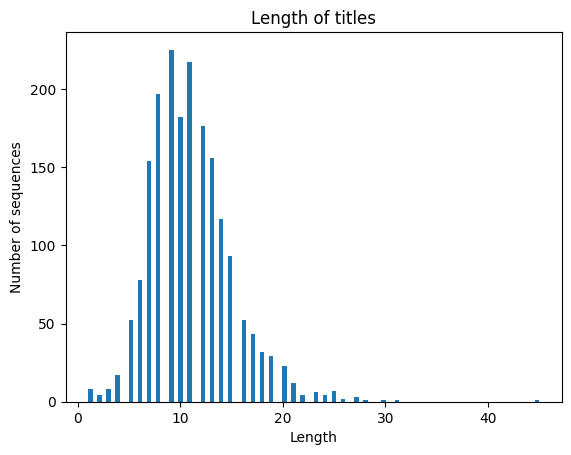

In [72]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
_ = plt.hist([len(text_ids) for text_ids in X_train_encoded['input_ids']], 100)
plt.xlabel("Length")
plt.ylabel("Number of sequences")
plt.title("Length of titles")

In [ ]:

tok_ds_train = tok_ds_train.remove_columns(["title"])
tok_ds_test = tok_ds_test.remove_columns(["text"])

tok_ds_train = tok_ds_train.rename_column("label", "labels")
tok_ds_test = tok_ds_test.rename_column("label", "labels")

In [ ]:

# Load BERT pre-trained model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the model
model.save_pretrained("./humor-classifier")
tokenizer.save_pretrained("./humor-classifier")



Explanation of the Script
Loading the Dataset:

We load the humor dataset from a CSV file with two columns: text and label. Then, we split the dataset into training and testing sets using train_test_split.
Tokenization:

We use BERT's tokenizer (BertTokenizer.from_pretrained) to preprocess the text data. The preprocess_data function tokenizes each text entry, truncates it to a maximum length of 128 tokens, and adds padding where necessary.
Model Initialization:

We load the pre-trained BERT model for sequence classification using BertForSequenceClassification. The model is initialized with two output labels (num_labels=2) because we have a binary classification task (humorous or non-humorous).
Training Arguments:

We define the TrainingArguments with important parameters like learning rate (2e-5), batch size (16), number of epochs (3), and evaluation strategy.
Training the Model:

The Trainer class from Hugging Face simplifies the training process. It takes care of the training loop, evaluation, and logging. We pass our model, training arguments, and datasets to the Trainer.
Evaluation:

The trainer.evaluate() function evaluates the model on the test dataset.
Saving the Model:

After training, the model and tokenizer are saved so they can be reused later for prediction or further fine-tuning.
Step 4: Make Predictions on New Data
After fine-tuning the model, you can use it to predict whether new text samples are humorous or non-humorous:

python
Copy code


In [2]:
# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("./humor-classifier")
tokenizer = BertTokenizer.from_pretrained("./humor-classifier")

# Example text
texts = ["Why don’t scientists trust atoms? Because they make up everything!", 
         "The weather is nice today."]

# Tokenize the input text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to labels
labels = ['humorous' if pred == 1 else 'non-humorous' for pred in predictions]

print(labels)

NameError: name 'BertForSequenceClassification' is not defined